In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

# **Introduction**
In football life, every coach wants to buy only good players for the upcoming season. However, it is not always easy to define the player as high-level. The reasons are:
- The best player in a certain weak team might seem high-level,
- Reserve players of the strong teams might seem low-level,
- Popularity of a certain player might influence coaches' decision,
- Etc.

There will be useful (at least sometimes) to see what **Machine Learning** algorithms suggest because of their candid and mathematical approach.

<br>

**Classification task**: Predict the class of players. There are:
- 0 - High-level players
- 1 - Mid-level players
- 2 - Low-level players

## **Data**
The data consists of 2940 players of the TOP-5 leagues of Europe. The data is augmented by players of Spain, French, Germany, and Italy leagues (Previously, there was only England league in project-1). Players are split into **train**, **validation**, and **test** sets with proportions **0.8**, **0.1**, and **0.1** respectively.

- **X** is numerical features of players (shape of **X** matrix is (2940, 40)),
- **Y** is class of players ("Position").

In [2]:
data = pd.read_excel('players (extension).xlsx')

In [3]:
data

,Unnamed: 0,Name,Country,Current Rating,Potential Rating,Height (cm),Weight (kg),Preferred Foot,Birth Date,Age,Preferred Positions,Player Work Rate,Weak Foot,Skill Moves,Value (€),Wage (€),Team,Position,Kit Number,On loan from,Joined Club,Contract Length,Ball Control,Dribbling,Marking,Slide Tackle,Stand Tackle,Aggression,Reactions,Att. Position,Interceptions,Vision,Composure,Crossing,Short Pass,Long Pass,Acceleration,Stamina,Strength,Balance,Sprint Speed,Agility,Jumping,Heading,Shot Power,Finishing,Long Shots,Curve,FK Acc.,Penalties,Volleys,GK Positioning,GK Diving,GK Handling,GK Kicking,GK Reflexes,Specialities,Traits
0,0,Lionel Messi,Argentina,94,94,170,72,Left,"June 24, 1987",33,RW ST CF,Medium / Low,4,4,95500000,560000,FC Barcelona,RW,10,No,"1, 2004",2021,96,97,33,26,37,48,95,94,40,94,96,88,92,92,91,75,68,95,84,93,68,70,86,95,94,93,94,75,88,14,6,11,15,8,"Dribbler, Distance Shooter, Crosser, FK Specia...","Finesse Shot, Long Shot Taker (CPU AI Only), S..."
1,1,Cristiano Ronaldo,Portugal,93,93,187,83,Right,"Feb. 5, 1985",35,ST LW,High / Low,4,5,58500000,400000,Juventus,LS,7,No,"10, 2018",2022,92,89,28,24,32,63,96,95,29,82,95,84,83,77,88,85,78,71,91,87,95,89,95,94,93,81,76,85,87,14,7,11,15,11,"Dribbler, Distance Shooter, Acrobat, Clinical ...","Power Free-Kick, Flair, Long Shot Taker (CPU A..."
2,2,Neymar Jr,Brazil,92,92,175,68,Right,"Feb. 5, 1992",28,LW CAM,High / Medium,5,5,105500000,290000,Paris Saint-Germain,LW,10,No,"3, 2017",2022,95,96,35,29,30,51,92,87,36,90,94,87,87,81,94,81,49,84,89,96,61,62,80,87,85,88,89,92,87,15,9,9,15,11,"Speedster, Dribbler, Playmaker, Crosser, FK Sp...","Injury Prone, Flair, Speed Dribbler (CPU AI On..."
3,3,Virgil van Dijk,Netherlands,91,92,193,92,Right,"July 8, 1991",29,CB,Medium / Medium,3,2,90000000,245000,Liverpool,LCB,4,No,"1, 2018",2023,77,70,93,86,93,83,89,47,90,65,90,53,79,83,74,75,92,53,79,61,90,87,81,52,64,60,70,62,45,11,13,10,13,11,"Tackling, Tactician, Strength, Complete Defender","Leadership, Long Passer (CPU AI Only), Power H..."
4,4,Jan Oblak,Slovenia,91,93,188,87,Right,"Jan. 7, 1993",27,GK,Medium / Medium,3,1,77500000,125000,Atlético Madrid,GK,13,No,"16, 2014",2023,30,12,27,18,12,34,88,11,19,65,68,13,43,40,43,41,78,49,60,67,78,15,59,11,12,13,14,11,13,90,87,92,78,89,No,"GK Long Throw, Comes For Crosses"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2935,Jonas Hupe,Germany,51,65,200,93,Right,"Dec. 1, 1999",20,GK,Medium / Medium,3,1,70000,2500,Borussia Dortmund,Res,20,No,". 17, 2019",2020,11,8,11,12,9,20,47,6,13,31,32,15,21,20,29,24,82,22,42,28,41,11,36,7,6,15,8,10,6,43,66,45,48,47,No,No
2936,2936,Leo Oppermann,Germany,51,67,184,72,Right,"Aug. 28, 2001",19,GK,Medium / Medium,3,1,60000,1500,1. FC Union Berlin,Res,39,No,". 3, 2019",2020,16,6,7,9,10,24,32,3,12,21,18,12,22,26,23,20,36,45,24,25,59,11,35,8,7,14,11,9,7,46,56,52,47,54,No,No
2937,2937,Jake Young,England,51,65,186,77,Right,"July 22, 2001",19,ST,Medium / Medium,2,2,70000,1500,Sheffield United,Res,44,No,"2, 2019",2021,46,41,13,13,17,33,43,47,12,33,39,28,39,22,63,50,62,49,68,59,69,52,56,52,44,39,22,59,50,8,13,9,12,10,No,No
2938,2938,Devid Eugene Bouah,Italy,49,72,177,74,Right,"Aug. 13, 2001",19,RB,Medium / Medium,2,2,60000,1500,Roma,Res,54,No,"l 22, 2020",2024,33,53,41,50,48,45,52,47,51,31,38,40,31,23,63,62,53,69,61,50,59,44,28,22,22,26,26,33,29,13,14,5,11,11,No,Injury Prone


In [4]:
## creating X matrix and y ##

x = data.loc[:, ['Weak Foot', 'Skill Moves', 'Value (€)',	'Wage (€)', 'Acceleration', 'Stamina', 'Strength', 'Balance',
                 'Sprint Speed', 'Agility', 'Jumping', 'Ball Control', 'Dribbling',	'Marking', 'Slide Tackle', 'Stand Tackle',
                 'Aggression', 'Reactions', 'Att. Position', 'Interceptions',	'Vision',	'Composure', 'Crossing', 'Short Pass',
                 'Long Pass', 'Heading', 'Shot Power', 'Finishing', 'Long Shots',	'Curve', 'FK Acc.',	'Penalties', 'Volleys',
                 'GK Positioning', 'GK Diving', 'GK Handling', 'GK Kicking', 'GK Reflexes']].values.copy()
y = data.loc[:, 'Current Rating'].values.copy()

In [5]:
## converting labels of players from string to integer ##

for i, player in enumerate(y):
  if player >= 80:
    y[i] = 0
  elif 80 > player >= 70:
    y[i] = 1
  else:
    y[i] = 2

y = y.astype(np.int32)

In [6]:
## normalization of X ##

norm_x = scale(x)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [7]:
## splitting the data ##

x_train, x_val_test, y_train, y_val_test = train_test_split(norm_x, y, test_size = 0.2, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state = 1)

In [8]:
class Dataset(Dataset):

  def __init__(self, train_val_test):
    if train_val_test == 'train':
      self.x = torch.tensor(x_train).type(torch.FloatTensor)
      self.y = torch.tensor(y_train).type(torch.LongTensor)
      self.len = len(y_train)
    elif train_val_test == 'val':
      self.x = torch.tensor(x_val).type(torch.FloatTensor)
      self.y = torch.tensor(y_val).type(torch.LongTensor)
      self.len = len(y_val)
    elif train_val_test == 'test':
      self.x = torch.tensor(x_test).type(torch.FloatTensor)
      self.y = torch.tensor(y_test).type(torch.LongTensor)
      self.len = len(y_test)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.len

# **Modeling**

In [9]:
train_set = Dataset(train_val_test = 'train')
val_set = Dataset(train_val_test = 'val')
test_set = Dataset(train_val_test = 'test')

In [10]:
def train(model, criterion, train_loader, val_set, optimizer, epochs):

  i = 0
  useful_stuff = {'training_loss': [], 'validation_loss': []}  

  for epoch in range(epochs):
    model.train()
    for i, (x, y) in enumerate(train_loader):
      optimizer.zero_grad()
      z = model(x)
      loss = criterion(z, y)
      loss.backward()
      optimizer.step()
    useful_stuff['training_loss'].append(loss.data.item())
    model.eval()
    useful_stuff['validation_loss'].append(criterion(model(val_set.x), val_set.y).item())
    
  return useful_stuff

In [11]:
def accuracy(model, data_set):
  _, y_hat = torch.max(model(data_set.x), 1)
  return (y_hat == data_set.y).numpy().mean()

## SoftMax


In [12]:
class SoftMax(torch.nn.Module):

  def __init__(self, input_size, output_size, p = 0):
    super(SoftMax, self).__init__()
    self.linear = torch.nn.Linear(input_size, output_size)
        
  def forward(self, x):
    z = self.linear(x)
    return z

In [13]:
softmax_lr = 0.005
softmax_epochs = 1000
softmax_batch_size = 294 ## 0.1 of the size of train_set ##

softmax_train_loader = DataLoader(dataset = train_set, batch_size = softmax_batch_size)
softmax_model = SoftMax(input_size = x.shape[1], output_size = 3)
softmax_optimizer = torch.optim.Adam(softmax_model.parameters(), lr = softmax_lr)
softmax_criterion = torch.nn.CrossEntropyLoss()

In [14]:
softmax_results = train(softmax_model, criterion = softmax_criterion, train_loader = softmax_train_loader,
                        val_set = val_set, optimizer = softmax_optimizer, epochs = softmax_epochs)

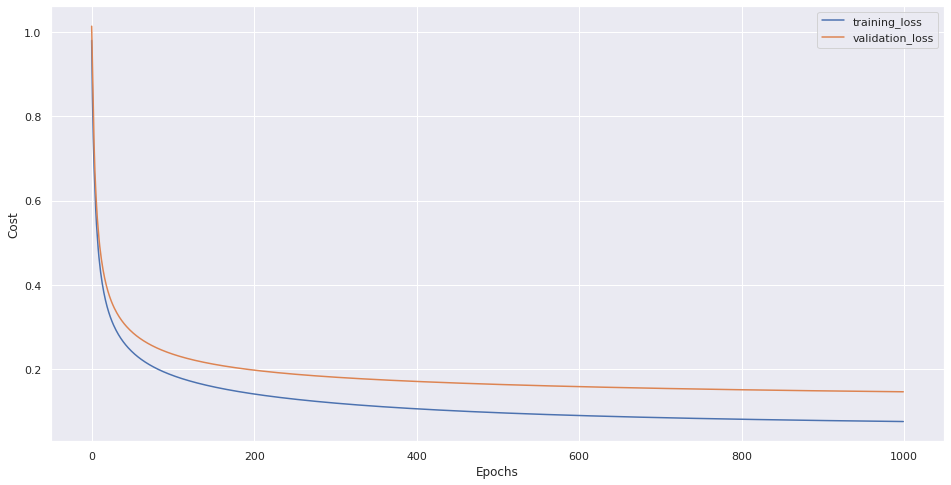

In [15]:
plt.figure(figsize = (16, 8))
plt.plot(softmax_results['training_loss'], label = 'training_loss')
plt.plot(softmax_results['validation_loss'], label = 'validation_loss')
plt.ylabel('Cost')
plt.xlabel('Epochs')   
plt.legend()
plt.show()

## Shallow Neural Network

In [16]:
shallow_layer = 5
shallow_lr = 0.005
shallow_epochs = 300
shallow_batch_size = 294 ## 0.1 of the size of train_set ##
shallow_p = 0.2 ## Dropout p ##

shallow_train_loader = DataLoader(dataset = train_set, batch_size = shallow_batch_size)
shallow_model = torch.nn.Sequential(torch.nn.Linear(x.shape[1], shallow_layer), torch.nn.Dropout(p = shallow_p),
                                    torch.nn.ReLU(), torch.nn.BatchNorm1d(shallow_layer),
                                    torch.nn.Linear(shallow_layer, 3), torch.nn.Softmax())
shallow_optimizer = torch.optim.Adam(shallow_model.parameters(), lr = shallow_lr)
shallow_criterion = torch.nn.CrossEntropyLoss()

In [17]:
shallow_results = train(shallow_model, criterion = shallow_criterion, train_loader = shallow_train_loader,
                        val_set = val_set, optimizer = shallow_optimizer, epochs = shallow_epochs)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


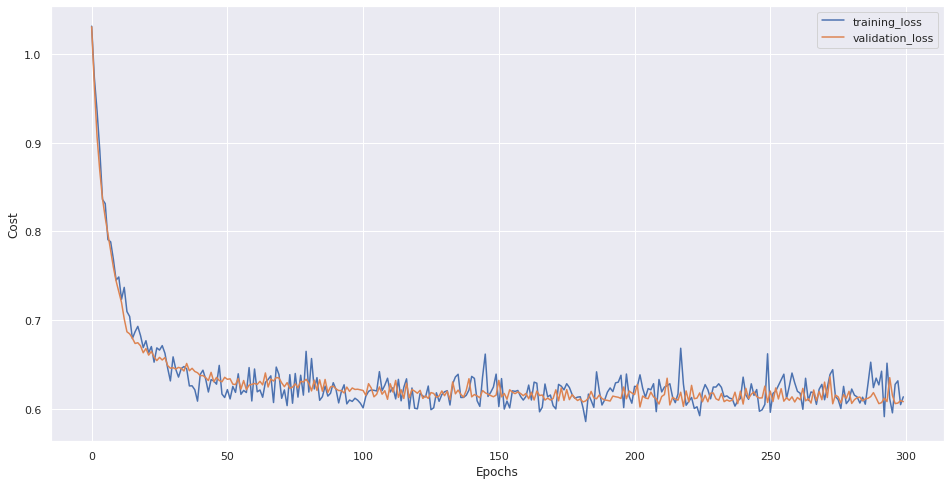

In [18]:
plt.figure(figsize = (16, 8))
plt.plot(shallow_results['training_loss'], label = 'training_loss')
plt.plot(shallow_results['validation_loss'], label = 'validation_loss')
plt.ylabel('Cost')
plt.xlabel('Epochs')   
plt.legend()
plt.show()

## Deep Neural Network

In [19]:
class DeepNeuralNetwork(torch.nn.Module):

  def __init__(self, layers, p):
    super(DeepNeuralNetwork, self).__init__()
    self.hidden = torch.nn.ModuleList()
    self.drop = torch.nn.Dropout(p = p) ## Dropout Regularization ##
    self.BatchNorm = list() ## Batch Normalization ##
    for input_size, output_size in zip(layers, layers[1:]):
      linear = torch.nn.Linear(input_size, output_size)
      torch.nn.init.kaiming_uniform_(linear.weight, nonlinearity='leaky_relu') ## He initialization ##
      self.hidden.append(linear)
      self.BatchNorm.append(torch.nn.BatchNorm1d(output_size)) ## Batch Normalization ##

  def forward(self, activation):
    L = len(self.hidden)
    for (l, linear_transform) in zip(range(L), self.hidden):
      if l < L - 1:
        activation = self.BatchNorm[l](torch.nn.functional.leaky_relu(self.drop(linear_transform(activation))))
      else:
        activation = linear_transform(activation)
    return activation

In [20]:
deep_layers = [x.shape[1], 10, 10, 3]
deep_lr = 0.005
deep_epochs = 300
deep_batch_size = 294 ## 0.1 of the size of train_set ##
deep_p = 0.25 ## Dropout p ##

deep_train_loader = DataLoader(dataset = train_set, batch_size = deep_batch_size)
deep_model = DeepNeuralNetwork(deep_layers, p = deep_p)
deep_optimizer = torch.optim.Adam(deep_model.parameters(), lr = deep_lr)
deep_criterion = torch.nn.CrossEntropyLoss()

In [21]:
deep_results = train(model = deep_model, criterion = deep_criterion, train_loader = deep_train_loader, val_set = val_set,
                     optimizer = deep_optimizer, epochs = deep_epochs)

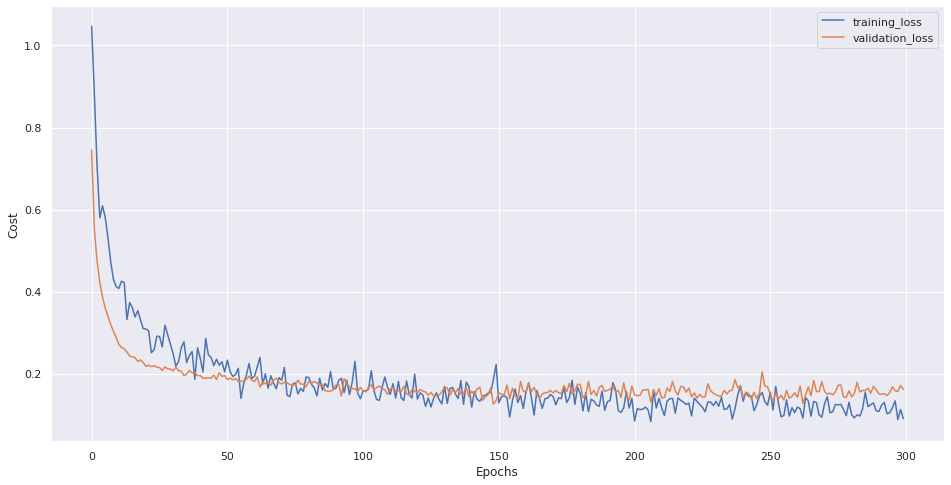

In [22]:
plt.figure(figsize = (16, 8))
plt.plot(deep_results['training_loss'], label = 'training_loss')
plt.plot(deep_results['validation_loss'], label = 'validation_loss')
plt.ylabel('Cost')
plt.xlabel('Epochs')   
plt.legend()
plt.show()

# **Discussion**
In the table below, we see the results of the performance of each model. I tried to apply all methods which we covered for the <a href="https://www.coursera.org/learn/deep-neural-networks-with-pytorch" target="_blank">course</a> (e.g. **He initialization** for ReLU, **Dropout Regularization** for Hidden layers, **Batch Normalization**, **Adam GD**). Also, I added new players to the data to increase the accuracy of the models on the validation and test sets. However, these things couldn't help me with the problem of accuracy unless I looked at the nature of the data and changed the task of the models (previously there were: prediction the role of the player of English Premier League (player of starting lineup or reserve player), prediction the role of player of TOP-5 leagues (player of starting lineup or reserve player), prediction of the position of the player).

In [23]:
pd.DataFrame(data = {'Train': [accuracy(softmax_model, train_set), accuracy(shallow_model, train_set), accuracy(deep_model, train_set)],
                     'Validation': [accuracy(softmax_model, val_set), accuracy(shallow_model, val_set), accuracy(deep_model, val_set)],
                     'Test': [accuracy(softmax_model, test_set), accuracy(shallow_model, test_set), accuracy(deep_model, test_set)]},
             index = ['SoftMax', 'Shallow Neural Network', 'Deep Neural Network'])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


,Train,Validation,Test
SoftMax,0.960034,0.935374,0.948980
Shallow Neural Network,0.966837,0.945578,0.948980
Deep Neural Network,0.972364,0.938776,0.955782


# **Conclusion**
From the results, we see that all three algorithms classify players equally very well. Because of good results, coaches can rely on **ML** in controversial cases.
